## Slice Sampling

Slice sampling is a Markov Chain Monte Carlo technique that tries to cut down on the amount of tuning needed to get a sample from the asymptotic distribution. Here I will try to explain it to myself.

Suppose we have a distribution (or something proportional to one): $ p(x) $. We pick a point $ x_0.$ Then we find a $ y_0 = p(x_0)$

<img src="slice-sampling-fig1.png" width=50%/>

Next, pick a point using a uniform random number generator on the interval $[0,y_0]$: this gives us $y$, 
$y = \text{Uniform}[0, y_0]$. $y$ defines a 'height' at the point $x_0$ that is below the probablility density. This also defines a _slice_ across $p(x)$ at height $y$, I'll call it $\cal{S}$. Now $\cal S$ is an interval, but of course we _don't_ know where it ends at either high or low values of $x$ yet.

<img src="slice-sampling-fig2.png" width=50%/>

Pick a width $w$, and let $L = x_0 - w$ and $R = x_0 + w.$ Next, grow the width until $L$ and $R$ lie _outside_ $\cal S$.  This can be detected by when both $p(L)$ and $p(R)$ are both _less_ than $y$: $p(L) < y \text{ and } p(R) < y.$

There are various choices for growing $w$ to find the edges of the slice: muliplicative, additive, etc.

Next, find a point in $\cal S$ by picking a point $x_1$ (randomly) in $[L,R]$ such that $ y < p(x_1)$ :

- if you fail, just try again with a new random number, until you hit it.
- if you miss, you can (carefully) shrink the interval until you get an acceptable point.

The point $x_1$ that is accepted will be a sample from the distribution.

See: Neal, "Slice Sampling," _The Annals of Statistics_ 2003, vol. 31 (705-767). This is available online.

### Note on the vector/linear algebra conventions in Julia

This is a useful page from stackoverflow: <https://stackoverflow.com/questions/21152051/difference-between-nx1-array-and-n-element-array-in-julia> on the array vs. vector deal in Julia.

From user Matt B.:

>It's much more instructive, though, to think about why this matters. Julia's type system is designed to be entirely based upon types, not values. The dimensionality of an array is included in its type information, but the number of rows and columns is not. As such, the difference between a nx1 matrix and a n-element vector is that they have different types… and the type inference engine isn't able to see that the matrix only has one column.

>To get the best performance from Julia, you (and especially the core language and library designers) want to write functions that are type stable. That is, functions should be able to deduce what type they will return purely based upon the types of the arguments. This allows the compiler to follow your variables through functions without losing track of the type… which in turn allows it to generate very highly optimized code for that specific type.

>Now, think about transposes again. If you want a type stable transpose function, it must return at least a two-dimensional array. It simply can't do something tricky if one of the dimensions is 1 and still maintain good performance.

So I summarize:

    [1 1 1] # 1x3 matrix
    [1 1 1]'# 3x1 matrix
    [1,1,1] # row vector

In [1]:
using Plots
gr(fmt="png") #THIS IS NEEDED FOR SPEED in notebooks. SVG with many points is sloooowwww...

Plots.GRBackend()

In [2]:
# using LinearAlgebra # for dot function   #Not in Julia 0.6

LoadError: [91mArgumentError: Module LinearAlgebra not found in current path.
Run `Pkg.add("LinearAlgebra")` to install the LinearAlgebra package.[39m

In [3]:
function g2(x,xa)
    return -0.5*dot(x,x)
end

g2 (generic function with 1 method)

In [4]:
function rectpdf(v,xa)
    x = v[1]
    y = v[2]
    if x > 1 && x < 9 && y > 3 && y < 7
        return 0.0
    else
        return -Inf
    end
end


rectpdf (generic function with 1 method)

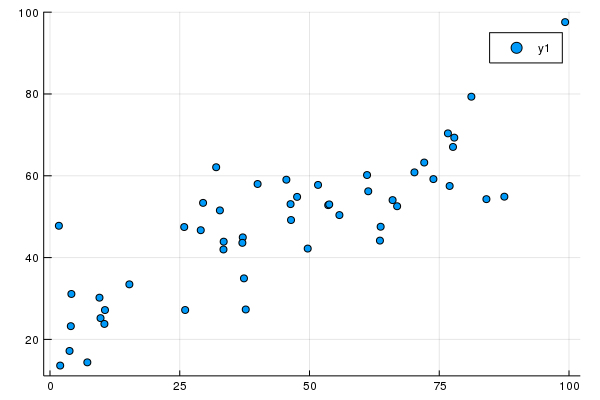

In [5]:
theta_true = [25.0 0.5] # [intercept slope]
xdata = 100*rand(50);
ydata = theta_true[1] .+ theta_true[2]*xdata
n = 10*randn(50)
ydata += n
scatter(xdata, ydata)

In [6]:
function log_prior(theta)
    alpha, beta, sigma = theta
    if sigma < 0
        return -Inf   # log(0)
    else
        return -0.5 * log(1 + beta^2) - log(sigma)  #Jeffreys prior for slopes
    end
end

log_prior (generic function with 1 method)

In [7]:
log_prior([24 .4 5])

-1.683647914993237

In [8]:
function log_like(theta, xvec)
    alpha, beta, sigma = theta
    x = xvec[1]
    y = xvec[2]
    y_model = alpha .+ beta .* x
    return -0.5 * sum(log(2*pi*sigma^2) .+ (y - y_model).*(y - y_model) / sigma^2)
    #return y - y_model
end

log_like (generic function with 1 method)

In [9]:
function log_posterior(theta, xvec)
    return log_prior(theta) + log_like(theta,xvec)
end

log_posterior (generic function with 1 method)

In [10]:
print(log_posterior([25 .5 10], [xdata, ydata]))
#[xdata, ydata]

-185.40654819966983

In [11]:
function mslicer(g, dim, x0, xargs; N=1000, w=0.5, m=10)
    #=VERSION FOR VECTOR FIXES=#
    #= multi-D slice sampler, g: log of distribution function, 
    dim number of dimensions
    x0: start (or next) point, values of distribution parameters. x1: next point.
    xargs: extra arguments for distribution, Nm samples to return,
        w: "out step" distance, m: max number of outward steps.
    Returns N x dim array.
    Steps successively in each direction in the sample space, so it produces
    dim*N samples as currently written.
    
    Note that you only have to worry about log scaling in 'vertical' comparisons
    in these Monte Carlo chain calculations.
    
    NOTE: this needs to be checked for the whole julia
    vector vs matrix thing: what is  [1 2 3] vs [1,2,3]
    =#
    xs = zeros(N, dim)  # array that will be returned
    xs[1,:] = x0  #x0 should be array 1,dim; needs [1.0 1.0] syntax for this version.
    #print(x0)
    x1 = zeros(1,dim)
    L = zeros(1,dim)
    R = zeros(1,dim)
    way = zeros(1,dim)  # which axis to go along in space
    i = 2    # assumed start values for chain are recorded at xs[1,1]
    while i <= N
        for d in 1:dim       # go one step in each dimensional direction.
            way = 0.0 * way #clear it
            way[d] = 1.0 #set nonzero in direction we go for slicing on this step
            y0 = g(x0,xargs)  #height of distribution at x0
            y = y0 + log(rand()) # height for slice (using log scaled distribution)
            #start stepping out
            U = rand()   # between 0 and 1
            L = x0 - (w * way * U)
            R = L .+ w .* way
            
            V = rand()
            J = floor(m*V)
            K = (m - 1) - J
            while J > 0 && y < g(L,xargs)
                L = L .- w .* way
                J = J - 1
            end
            while K > 0 && y < g(R,xargs)
                R = R .+ w .* way
                K = K - 1
            end
            #now should be stepped out beyond distribution at slice level
            # work back in if no value found:
            Lbar, Rbar = L, R
            while true 
                U = rand()
                x1 = Lbar .+ U .* (Rbar .- Lbar)  # vector subtraction should be correct dir
                if y < g(x1,xargs)
                    break # exit while loop
                end
                if x1[d] < x0[d]
                    Lbar = x1
                    else 
                    Rbar = x1
                end
            end
            xs[i,:] = x1 # found an acceptable point, record in chain (a row)
            x0 = x1 # set initial to new point for next round.
            i += 1
            if i > N
                break # catch case where we reach N in the middle of set of dimensions
            end
        end # for d
        end  #while i
    return xs 
end

mslicer (generic function with 1 method)

In [17]:
res = mslicer(log_posterior, 3, [30.0 0.6 10.0], [xdata, ydata], N=50000);

In [18]:
size(res)

(50000, 3)

In [19]:
A_chain = res[:,1]
B_chain = res[:,2]
N_chain = res[:,3]; # get the MCMC parameter chains out with convenient names (marginalized samplings)

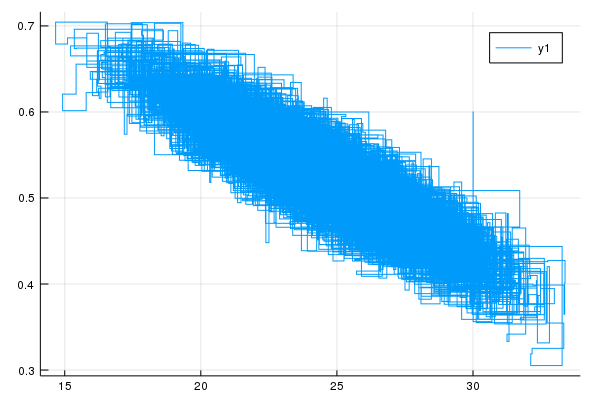

In [20]:
plot(A_chain,B_chain)

## Note: get the right function.

I have floating around in my directory two versions of this that I gave very similar names and I think are essentially the same function. I think `slicerm` is the latest, with updated 
comments, so I am going to copy it in here and test it.

In [20]:
function slicerm(g, dim, x0, xargs; N=1000, w=0.5, m=10)
    #= multi-D slice sampler, g: log of distribution function, 
    dim number of dimensions
    x0 start point, 
    xargs extra arguments for distribution, N*dim samples to return,
        w "out step" distance, m max number of outward steps.
    
        Note that you only have to worry about log scaling in 
        'vertical' comparisons
        in these Monte Carlo chain calculations.
    =#
    xs = zeros(N*dim,dim)  # array that will be returned
    xs[1,:] = x0  #x0 should be vector of length dim
    x1 = zeros(1,dim)
    L = zeros(1,dim)
    R = zeros(1,dim)
    way = zeros(1,dim)  # which axis to go along in space
    for i in 2:N*dim
        for d in 1:dim
            way = 0*way #clear it
            way[d] = 1.0 #set nonzero in direction we go for slicing
            y0 = g(x0,xargs)  #height of distribution at x0
            y = y0+log(rand()) # height for slice
            #start stepping out
            U = rand()   # between 0 and 1
            L = x0 - w*way*U
            R = L + w*way
            V = rand()
            J = floor(m*V)
            K = (m - 1) - J
            while J > 0 && y < g(L,xargs)
                L = L - w*way
                J = J - 1
            end
            while K > 0 && y < g(R,xargs)
                R = R + w*way
                K = K - 1
            end
            #now should be stepped out beyond distribution at slice level
            # work back in if no value found:
            Lbar, Rbar = L, R
            while true 
                U = rand()
                x1 = Lbar + U * (Rbar - Lbar)  # vector subtraction should be 
                        # correct dir
                if y < g(x1,xargs)
                    break # exit while loop
                end
                if x1[d] < x0[d]
                    Lbar = x1
                    else 
                    Rbar = x1
                end
            end
            xs[i,:] = x1 # found an acceptable point, record in chain (a row)
            x0 = x1 # set initial to new point for next round.
        end # for d
    end  #for N
    return xs 
end
    
    


slicerm (generic function with 1 method)

In [21]:
res_sm = slicerm(log_posterior, 3, [30.0 0.6 10.0], [xdata, ydata], N=500);

In [22]:
A_chain = res_sm[:,1]
B_chain = res_sm[:,2]
N_chain = res_sm[:,3]; # get the MCMC parameter chains out with convenient names (marginalized samplings)

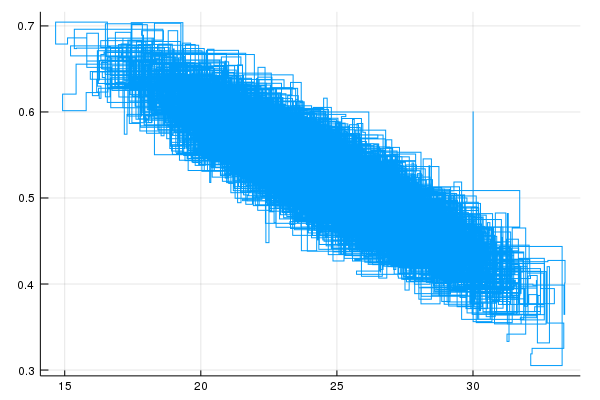

In [21]:
plot(A_chain,B_chain, legend=false)

Ouch, they are **Not equivalent!**

In [24]:
A_chain

1500-element Array{Float64,1}:
 30.0              
 28.987191083166483
 30.850938374093595
 28.970687959443424
 29.201106689080227
 27.674966634014954
 27.620016258439474
 29.187144333732043
 31.254022995403588
 27.617027655571704
 23.68851966799835 
 19.88163385653246 
 20.608525188097097
  ⋮                
 17.608643780761394
 17.765358950049357
 19.98549025994402 
 20.102243683158424
 19.767424356681037
 18.403997522429037
 17.306876675122744
 17.366712056908373
 18.255529981535553
 20.065421244997964
 23.6436657146037  
 24.169333911173005

## Difference between mslicer and slicerm

`slicerm` makes an array 3 times longer in this case: I think it is the one that steps in each direction for the iteration loop. It uses a `for` loop.

`mslicer` makes a chain of exactly the number requested (500 above). I think it may be the latest. I am going to have to look in the Dropbox history.

**These both may be 'correct'.** There is some subtle difference, I think it may be that 
`slicerm` steps in all directions before recording? For now I will go with `mslicer` in my other file for today `2018-10-21`

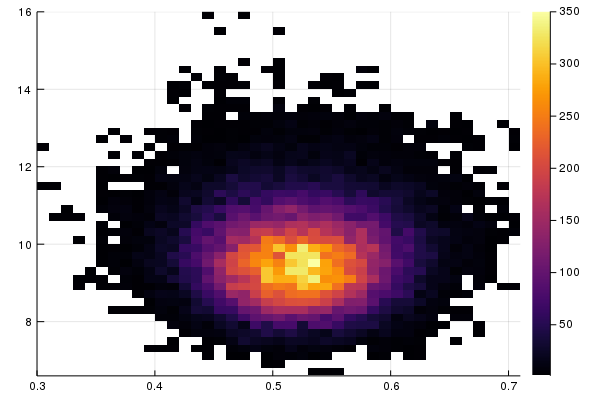

In [27]:
histogram2d(B_chain, N_chain)

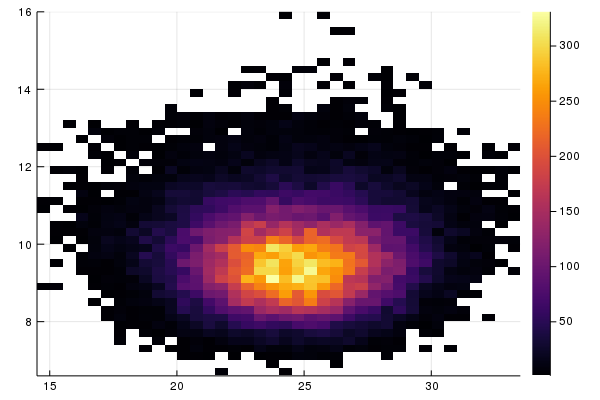

In [28]:
histogram2d(A_chain, N_chain)

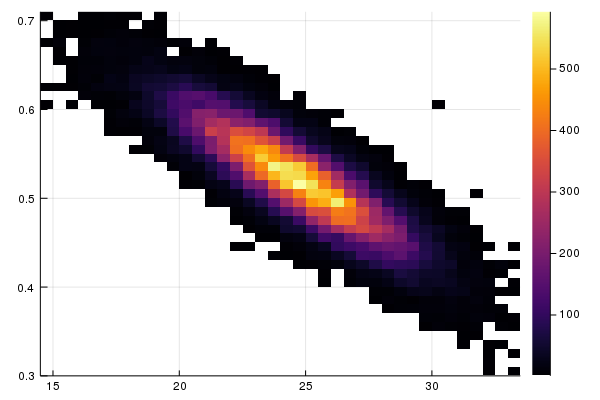

In [29]:
histogram2d(A_chain, B_chain)